In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from copy import deepcopy
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from data import read_audio, AudioData
from data.metadata.vcc import (
    SanityMetadata, VCC2016TrainMetadata,
    VCC2016TrainAppendedMetadata)
import data.transform
from data.transform import log_stft, db_to_amp, dft_filter
from data.dataset import (
    TaskDataset, InputData,
    from_gen_model_output, to_gen_model_output)
from env import sr, frame_size
from loss import MSE, MelMSE, MelMeanFilteredMSE, MelGaussianFilteredMSE, \
    ScaledMSE
from models import save_model, load_model
from models.vae import ToyAE, MultiFeaturePerceptron, CustomModel
from maml import reptile_train
from visualization import plot_spec
from vocoder import griffin_lim
from utils import get_model_param_count

plt.style.use({'figure.facecolor':'white'})

C:\Programs\Anaconda3\envs\pytorch-geometric\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


In [3]:
def sound(x, rate=sr, label=''):
    from IPython.display import display, Audio, HTML
    display(HTML(
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>'
        + label + '</td><td>' + Audio(x, rate=rate)._repr_html_()[3:]
        + '</td></tr></table>'
    ))

def sci(num):
    return '{:e}'.format(num)

In [4]:
# meta_data = SanityMetadata()
# meta_data = VCC2016TrainMetadata()
meta_data = VCC2016TrainAppendedMetadata()

In [5]:
from models.split_model import AutoEncoderDataset
auto_encoder_dataset = AutoEncoderDataset(meta_data)
print('Auto encoder data loaded', datetime.now())

Auto encoder data loaded 2021-12-15 07:36:11.105927


# Train encoder/decoder

In [6]:
from models.split_model import FormantCoder

In [7]:
device = torch.device('cuda')
formant_coder = FormantCoder().to(device)

# criterion = MSE()
formant_coder_criterion = nn.MSELoss()
# formant_coder_criterion = ScaledMSE()

# criterion = nn.L1Loss()
# criterion = MelMSE(is_input_log_amp=True, n_mel=512)
# criterion = MelMeanFilteredMSE(max_filter_size=10)
# criterion = MelGaussianFilteredMSE(max_filter_size=8)
if isinstance(formant_coder_criterion, nn.Module):
    formant_coder_criterion = formant_coder_criterion.to(device)

formant_coder_optimizer = optim.Adam(
    formant_coder.parameters(), lr=2e-3, weight_decay=0)

In [8]:
np.random.seed(0)
torch.manual_seed(0)
def train_formant_coder(
        model, n_iter=2000, log_period=20, test_proportion=0.3):
    model.train()
    for i in range(n_iter):
        idx = np.random.randint(auto_encoder_dataset.n_audios)
        x, _ = auto_encoder_dataset[idx]
        x = torch.from_numpy(x.astype(np.float32))
        x = x.transpose(0, 1)
        x = x.to(device)
        if test_proportion is None or test_proportion == 0:
            train_x = x
        else:
            test_indices = np.random.choice(x.shape[0],
                                            int(x.shape[0] * test_proportion))
            mask = np.zeros(x.shape[0], dtype=bool)
            mask[test_indices] = True
            test_x = x[mask]
            train_x = x[~mask]
        formant_coder_optimizer.zero_grad()
        out = model(train_x)
        loss = formant_coder_criterion(out[:, :], train_x[:, :])
        loss.backward()
        formant_coder_optimizer.step()
        if log_period is not None and i % log_period == 0:
            print('Pass', i, ': ', sci(loss.item()), end='')
            if test_proportion is not None and test_proportion != 0:
                with torch.no_grad():
                    out = model(test_x)
                    loss = formant_coder_criterion(out[:, :], test_x[:, :])
                    print('; Test', i, ': ', sci(loss.item()), end='')
            print()
train_formant_coder(formant_coder)
save_model('saved_models/' +
           type(formant_coder).__name__ + '.pt', formant_coder)

Pass 0 :  2.272115e+03; Test 0 :  1.952368e+03
Pass 20 :  1.445505e+03; Test 20 :  1.260135e+03
Pass 40 :  5.306570e+02; Test 40 :  4.928627e+02
Pass 60 :  2.825205e+02; Test 60 :  2.652718e+02
Pass 80 :  2.373724e+02; Test 80 :  2.528270e+02
Pass 100 :  1.853391e+02; Test 100 :  1.934642e+02
Pass 120 :  1.807952e+02; Test 120 :  1.785076e+02
Pass 140 :  1.626690e+02; Test 140 :  1.472384e+02
Pass 160 :  1.249647e+02; Test 160 :  1.298528e+02
Pass 180 :  1.433312e+02; Test 180 :  1.518222e+02
Pass 200 :  1.677903e+02; Test 200 :  1.713050e+02
Pass 220 :  1.498931e+02; Test 220 :  1.499800e+02
Pass 240 :  1.442593e+02; Test 240 :  1.352797e+02
Pass 260 :  1.186953e+02; Test 260 :  1.158185e+02
Pass 280 :  8.755049e+01; Test 280 :  8.851523e+01
Pass 300 :  9.790683e+01; Test 300 :  9.526840e+01
Pass 320 :  8.808142e+01; Test 320 :  8.373781e+01
Pass 340 :  7.625491e+01; Test 340 :  6.887966e+01
Pass 360 :  7.068382e+01; Test 360 :  6.894019e+01
Pass 380 :  7.270293e+01; Test 380 :  7.618

In [9]:
formant_coder = load_model(
    'saved_models/' + type(formant_coder).__name__ + '.pt',
    FormantCoder).to(device)

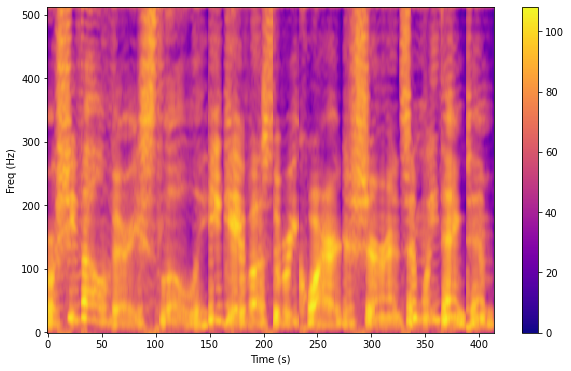

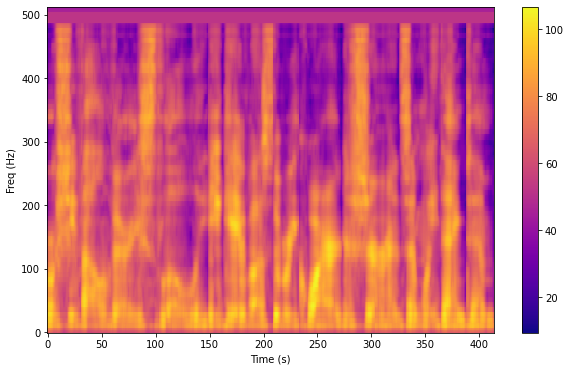

In [10]:
# test formant coder
with torch.no_grad():
    idx = 10
    x, _ = auto_encoder_dataset[idx]
    amp = auto_encoder_dataset.all_audios[idx].amp
    sound(griffin_lim(amp), label='Original')
    amp = auto_encoder_dataset.all_audios[idx].normalized_amp()
    lo, hi = dft_filter(log_stft(amp))
    hi = log_stft(amp) - lo
    plot_spec(x)
    x = torch.from_numpy(x.astype(np.float32))
    predicted = formant_coder(x.transpose(0, 1).to(device)).detach().cpu().numpy().T
    plot_spec(predicted)
    recon = lo.copy()
    recon[:, auto_encoder_dataset.all_audios[idx].selected_frames] = predicted
    sound(griffin_lim(db_to_amp(recon+hi)* np.sqrt(
        auto_encoder_dataset.all_audios[idx].frame_energy).reshape((1, -1))),
        label='Reconstructed')

# Train Formant transformer

In [11]:
from models.split_model import (
    FormantTransformer, SplitModelMetaDataset, SplitModelTaskDataset
)


formant_coder = load_model('saved_models/' +
           type(formant_coder).__name__ + '.pt', FormantCoder).to(device)

In [12]:
dataset = SplitModelMetaDataset(meta_data)
dataset.read_and_preprocess()
print('Split meta data loaded', datetime.now())

Split meta data loaded 2021-12-15 07:38:23.585548


In [13]:
class OptimizerMgr:
    def __init__(self):
        self.instance = None
    def create_instance(self, model):
        # self.instance = optim.SGD(model.parameters(),
        #                           lr=1e-3, weight_decay=0) # 2e-4
        # self.instance = optim.Adam(model.parameters(),
        #                            lr=1e-5, weight_decay=0)
        self.instance = optim.Adam(model.parameters(),
                                   lr=1e-3, weight_decay=0)

    def get(self):
        return self.instance

formant_transformer_optimizer_mgr = OptimizerMgr()

In [14]:
formant_transformer_criterion = nn.MSELoss()

# criterion = nn.L1Loss()
# criterion = MelMSE(is_input_log_amp=True, n_mel=512)
# criterion = MelMeanFilteredMSE(max_filter_size=10)
# criterion = MelGaussianFilteredMSE(max_filter_size=8)
if isinstance(formant_transformer_criterion, nn.Module):
    formant_transformer_criterion = formant_transformer_criterion.to(device)

def train_formant_transformer(model, x, y,
          n_iter=1000, log_period=None, test_proportion=0.2):
    # optimizer_mgr.create_instance(model)
    optimizer = formant_transformer_optimizer_mgr.get()
    model.train()
    # x = x.transpose(0, 1)
    # y = y.transpose(0, 1)
    x = x.to(device)
    y = y.to(device)
    if test_proportion is None or test_proportion == 0:
        train_x, train_y = x, y
    else:
        test_indices = np.random.choice(x.shape[0],
                                        int(x.shape[0] * test_proportion))
        mask = np.zeros(x.shape[0], dtype=bool)
        mask[test_indices] = True
        test_x, test_y = x[mask], y[mask]
        train_x, train_y = x[~mask], y[~mask]
        with torch.no_grad():
            test_y_decoded = formant_coder.decode(test_y)
    with torch.no_grad():
        train_y_decoded = formant_coder.decode(train_y)
    for i in range(n_iter):
        optimizer.zero_grad()
        out = model(train_x)
        # loss = criterion(out[:, :], train_y[:, :])
        loss = formant_transformer_criterion(
            formant_coder.decode(out), train_y_decoded)

        loss.backward()
        optimizer.step()
        if log_period is not None and i % log_period == 0:
            print('Pass', i, ': ', sci(loss.item()), end='')
            if test_proportion is not None and test_proportion != 0:
                with torch.no_grad():
                    out = model(test_x)
                    # loss = criterion(out[:, :], test_y[:, :])
                    loss = formant_transformer_criterion(
                        formant_coder.decode(out), test_y_decoded)
                    print('; Test', i, ': ', sci(loss.item()), end='')
            print()

Pass 0 :  3.507305e+02; Test 0 :  3.567581e+02
Pass 5 :  2.595956e+02; Test 5 :  2.640420e+02
Pass 10 :  2.112117e+02; Test 10 :  2.258286e+02
Pass 15 :  1.867301e+02; Test 15 :  1.994929e+02
Pass 20 :  1.682915e+02; Test 20 :  1.843062e+02
Pass 25 :  1.626864e+02; Test 25 :  1.784902e+02
Pass 30 :  1.548128e+02; Test 30 :  1.690687e+02
Pass 35 :  1.486892e+02; Test 35 :  1.618082e+02
Pass 40 :  1.437992e+02; Test 40 :  1.552965e+02
Pass 45 :  1.392906e+02; Test 45 :  1.506865e+02
Pass 50 :  1.352213e+02; Test 50 :  1.452505e+02
Pass 55 :  1.305892e+02; Test 55 :  1.386098e+02
Pass 60 :  1.258736e+02; Test 60 :  1.324847e+02
Pass 65 :  1.206393e+02; Test 65 :  1.252514e+02
Pass 70 :  1.149265e+02; Test 70 :  1.177047e+02
Pass 75 :  1.094654e+02; Test 75 :  1.115394e+02
Pass 80 :  1.041931e+02; Test 80 :  1.058334e+02
Pass 85 :  9.920763e+01; Test 85 :  9.971172e+01
Pass 90 :  9.411584e+01; Test 90 :  9.405228e+01
Pass 95 :  8.968240e+01; Test 95 :  8.964081e+01
Pass 100 :  8.621089e+01

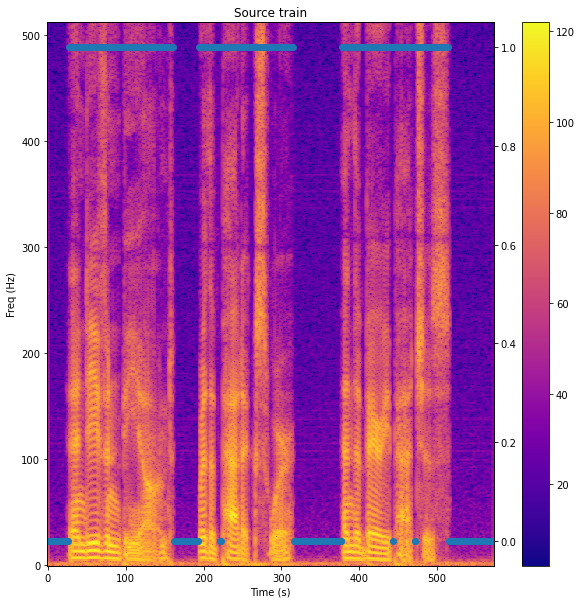

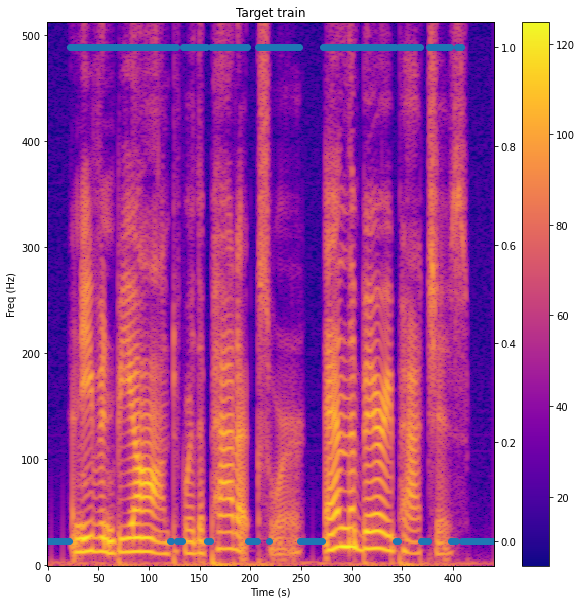

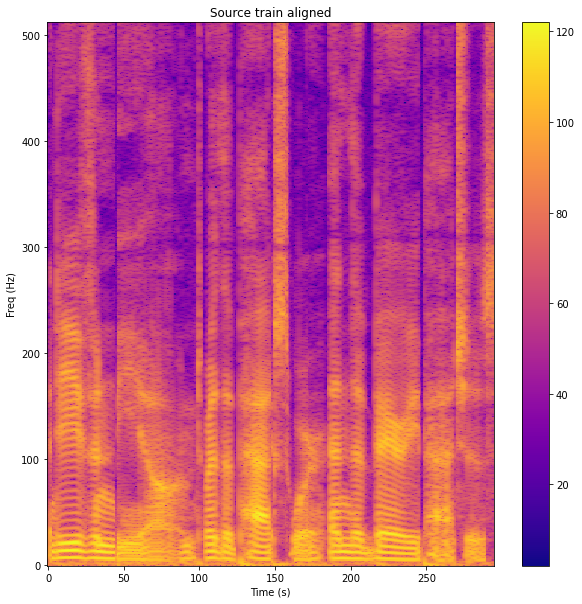

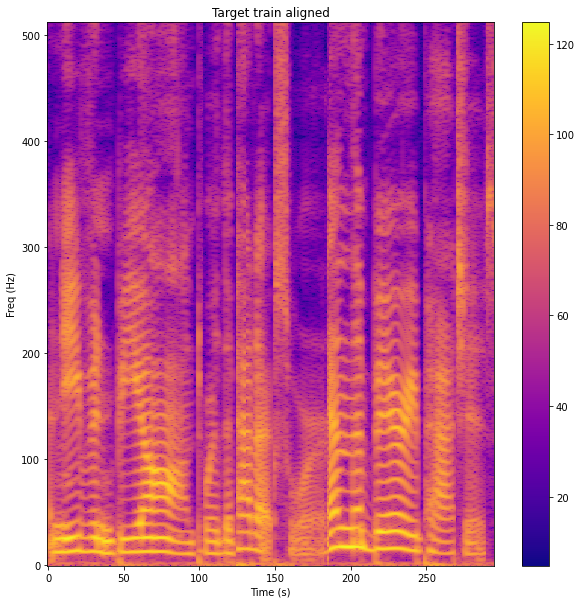

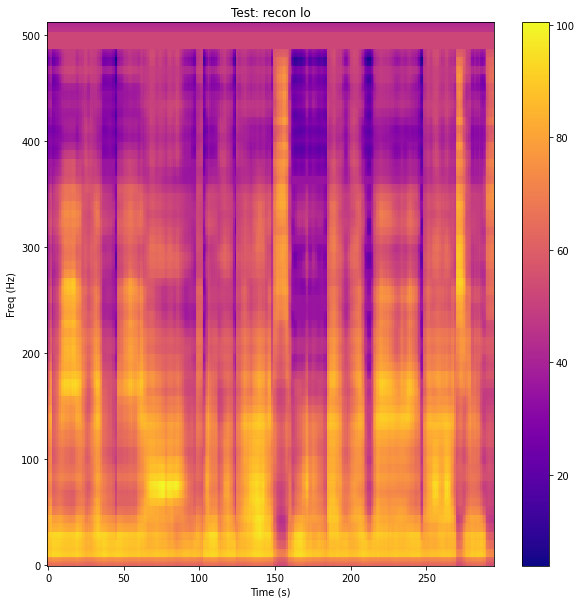

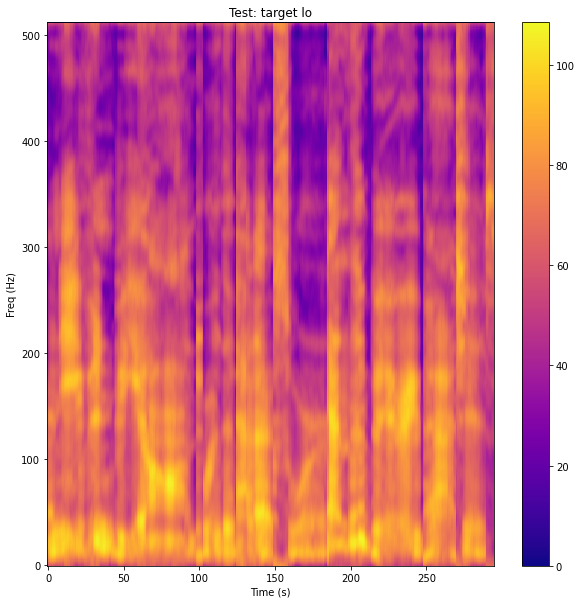

In [15]:
"""
This code block tests whether a model is "learnable" for a certain task
It simply fixes a single task and trains the model, and then it checks
model performance w.r.t. train set.
"""

formant_transformer = FormantTransformer().to(device)
formant_transformer_optimizer_mgr.create_instance(formant_transformer)

def formant_transformer_learnable_test(
        model, train_source_filename, train_target_filename, vocode=True):
    def to_lo(log_amp):
        lo, hi = dft_filter(log_amp)
        return lo
    def to_hi(log_amp):
        lo, hi = dft_filter(log_amp)
        return hi
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)
    # raw audio
    task_dat = SplitModelTaskDataset(train_source_filename,
                                     train_target_filename)
    plot_spec(log_stft(task_dat.source.amp), title='Source train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    sound(read_audio(train_source_filename), label='Source train')
    plot_spec(log_stft(task_dat.target.amp), title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)
    sound(read_audio(train_target_filename), label='Target train')
    # aligned audio
    amp_x_aligned, amp_y_aligned = task_dat.get_as_aligned_amp()
    plot_spec(log_stft(amp_x_aligned), title='Source train aligned',
              figure_size=(10,10))
    plot_spec(log_stft(amp_y_aligned), title='Target train aligned',
          figure_size=(10,10))
    if vocode:
        aligned_1 = griffin_lim(amp_x_aligned)
        aligned_2 = griffin_lim(amp_y_aligned)
        sound(aligned_1, label='Source train aligned')
        sound(aligned_2, label='Target train aligned')
        sound((aligned_1+aligned_2)/2, label='Combined aligned')

    # Generate task
    x, x_indices, y, y_indices = task_dat.get()
    x, y = log_stft(x.amp[:, x_indices]), log_stft(y.amp[:, y_indices])
    x, y = to_lo(x), to_lo(y)
    x = torch.from_numpy(x.astype(np.float32).T).to(device)
    y = torch.from_numpy(y.astype(np.float32).T).to(device)
    # transform to embedding
    with torch.no_grad():
        x = formant_coder.encode(x)
        y = formant_coder.encode(y)
    formant_transformer_optimizer_mgr.create_instance(model)
    train_formant_transformer(
        model, x, y,
        n_iter=500, log_period=5)

    def test_sample(test_task_dataset: SplitModelTaskDataset):
        from env import frame_size
        # Generate task
        x, x_indices, y, y_indices = test_task_dataset.get()
        x, y = log_stft(x.amp[:, x_indices]), log_stft(y.amp[:, y_indices])
        x, y_lo = to_lo(x), to_lo(y)
        y_hi = to_hi(y)
        x = torch.from_numpy(x.astype(np.float32).T).to(device)
        # transform to embedding
        with torch.no_grad():
            x = formant_coder.encode(x)
            x = formant_transformer.forward(x)
            x = formant_coder.decode(x)
            recon_lo = x.transpose(0,1).detach().cpu().numpy()
        plot_spec(recon_lo, title='Test: recon lo', figure_size=(10,10))
        plot_spec(y_lo, title='Test: target lo',figure_size=(10,10))
        if vocode:
            sound(griffin_lim(db_to_amp(recon_lo+y_hi)),
                  label='Test: estimate')
            sound(griffin_lim(db_to_amp(y_lo+y_hi)), label='Test: target')

    test_sample(task_dat)

formant_transformer_learnable_test(formant_transformer,
                                   meta_data.get(3, 0), meta_data.get(0, 0))


In [16]:
from copy import deepcopy

# Meta train

formant_transformer = FormantTransformer().to(device)
formant_transformer_optimizer_mgr.create_instance(formant_transformer)

torch.manual_seed(0)
np.random.seed(0)
def reptile_train(model, meta_dataset: SplitModelMetaDataset, n_shot,
                  n_iter_meta, meta_step_size,
                  inner_train_func, n_iter_inner=1000,
                  log_period_meta=10, log_period_inner=250, **kwargs):
    def to_lo(log_amp):
        lo, hi = dft_filter(log_amp)
        return lo
    # Reptile training loop
    for iteration in range(n_iter_meta):
        should_log = (log_period_meta is not None
                      and iteration % log_period_meta == 0)
        inner_log_period = log_period_inner if should_log else None
        weights_before = deepcopy(model.state_dict())
        # Generate task
        x, x_indices, y, y_indices = meta_dataset.sample()
        x, y = log_stft(x.amp[:, x_indices]), log_stft(y.amp[:, y_indices])
        x, y = to_lo(x), to_lo(y)
        x = torch.from_numpy(x.astype(np.float32).T).to(device)
        y = torch.from_numpy(y.astype(np.float32).T).to(device)
        # transform to embedding
        with torch.no_grad():
            x = formant_coder.encode(x)
            y = formant_coder.encode(y)
        # Do optimization on this task
        if should_log:
            print('Meta iter', iteration, ': ')
        inner_train_func(model, x, y, n_iter=n_iter_inner,
                         log_period=inner_log_period, **kwargs)
        # Interpolate between current weights and trained weights from this task
        # I.e. (weights_before - weights_after) is the meta-gradient
        weights_after = model.state_dict()
        step_size = meta_step_size * (
                1 - iteration / n_iter_meta)  # linear schedule
        model.load_state_dict(
            {name: weights_before[name] + (weights_after[name] -
                                           weights_before[name]) * step_size
             for name in weights_before})


reptile_train(formant_transformer, dataset, n_shot=None,
              n_iter_meta=2000, meta_step_size=5e-2,
              inner_train_func=train_formant_transformer, n_iter_inner=10,
              log_period_meta=50, log_period_inner=2)

save_model('saved_models/' + type(formant_transformer).__name__ + '.pt',
           formant_transformer)

Meta iter 0 : 
Pass 0 :  3.145972e+02; Test 0 :  2.782799e+02
Pass 2 :  2.601616e+02; Test 2 :  2.299291e+02
Pass 4 :  2.220119e+02; Test 4 :  1.964973e+02
Pass 6 :  1.946723e+02; Test 6 :  1.763593e+02
Pass 8 :  1.813692e+02; Test 8 :  1.678205e+02
Meta iter 50 : 
Pass 0 :  1.398131e+02; Test 0 :  1.443236e+02
Pass 2 :  1.335056e+02; Test 2 :  1.366664e+02
Pass 4 :  1.284613e+02; Test 4 :  1.319779e+02
Pass 6 :  1.260732e+02; Test 6 :  1.294412e+02
Pass 8 :  1.243814e+02; Test 8 :  1.279898e+02
Meta iter 100 : 
Pass 0 :  1.152178e+02; Test 0 :  9.967863e+01
Pass 2 :  1.120794e+02; Test 2 :  9.543688e+01
Pass 4 :  1.075993e+02; Test 4 :  9.426172e+01
Pass 6 :  1.065513e+02; Test 6 :  9.603982e+01
Pass 8 :  1.058749e+02; Test 8 :  9.541198e+01
Meta iter 150 : 
Pass 0 :  9.490070e+01; Test 0 :  9.372168e+01
Pass 2 :  8.868752e+01; Test 2 :  8.928505e+01
Pass 4 :  8.909425e+01; Test 4 :  8.592999e+01
Pass 6 :  8.091486e+01; Test 6 :  8.249737e+01
Pass 8 :  7.774297e+01; Test 8 :  8.568251

In [17]:
# Second train after meta training

formant_transformer = load_model('saved_models/' + FormantTransformer.__name__ + '.pt',
                              FormantTransformer).to(device)

Pass 0 :  8.100546e+01; Test 0 :  7.319268e+01
Pass 5 :  6.698798e+01; Test 5 :  6.161129e+01
Pass 10 :  6.379005e+01; Test 10 :  6.058047e+01
Pass 15 :  6.137816e+01; Test 15 :  5.869817e+01
Pass 20 :  5.972795e+01; Test 20 :  5.744981e+01
Pass 25 :  5.860004e+01; Test 25 :  5.662361e+01
Pass 30 :  5.772688e+01; Test 30 :  5.572588e+01
Pass 35 :  5.685207e+01; Test 35 :  5.512944e+01
Pass 40 :  5.614021e+01; Test 40 :  5.426083e+01
Pass 45 :  5.551160e+01; Test 45 :  5.348671e+01
Pass 50 :  5.491254e+01; Test 50 :  5.322788e+01
Pass 55 :  5.435163e+01; Test 55 :  5.265585e+01
Pass 60 :  5.383398e+01; Test 60 :  5.210779e+01
Pass 65 :  5.332870e+01; Test 65 :  5.185104e+01
Pass 70 :  5.286218e+01; Test 70 :  5.140412e+01
Pass 75 :  5.240089e+01; Test 75 :  5.108356e+01
Pass 80 :  5.193653e+01; Test 80 :  5.060656e+01
Pass 85 :  5.147143e+01; Test 85 :  5.025232e+01
Pass 90 :  5.099794e+01; Test 90 :  4.989757e+01
Pass 95 :  5.053462e+01; Test 95 :  4.951548e+01
Pass 100 :  5.007646e+01

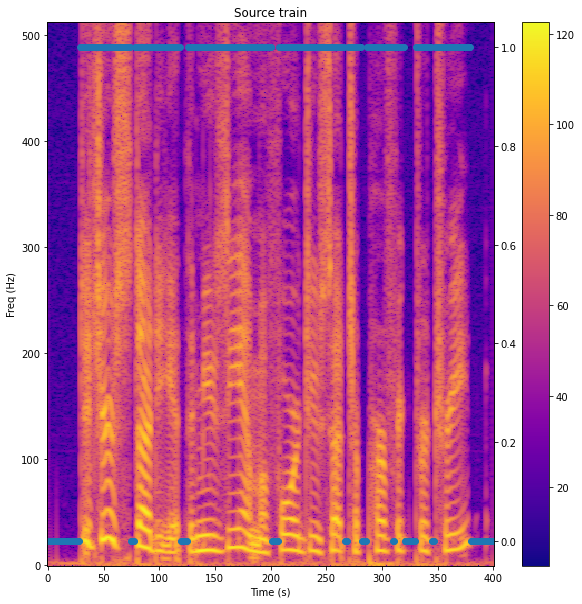

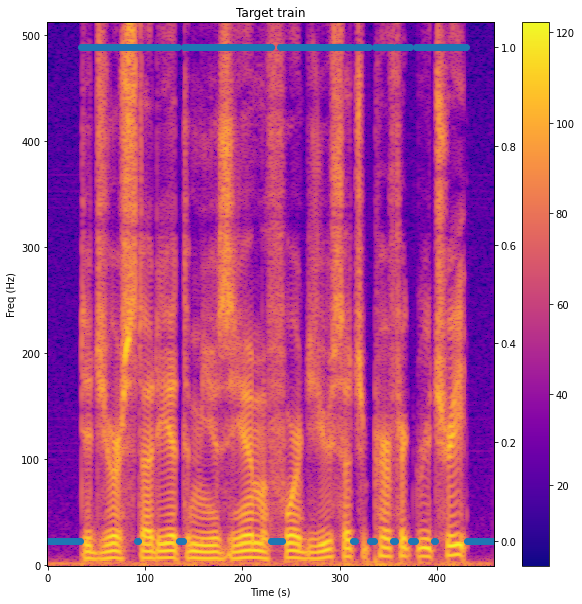

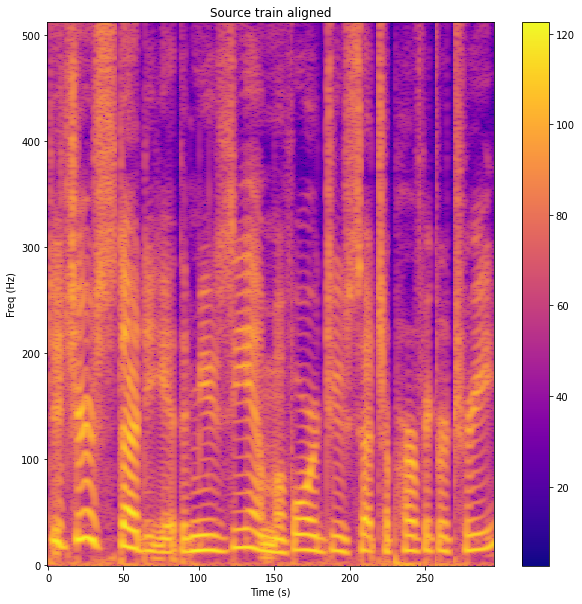

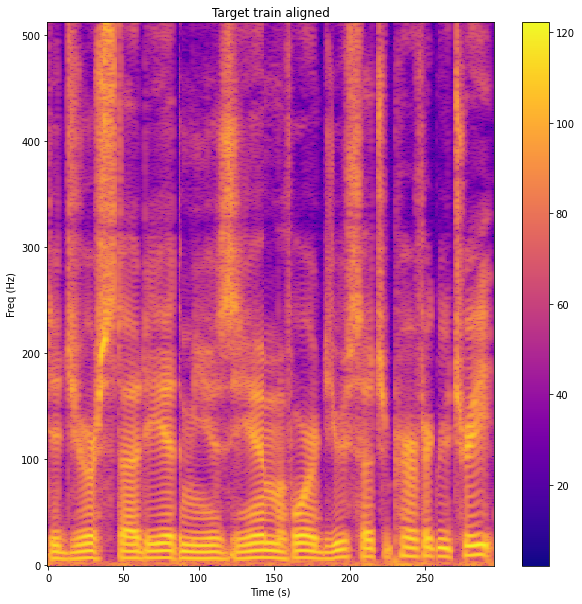

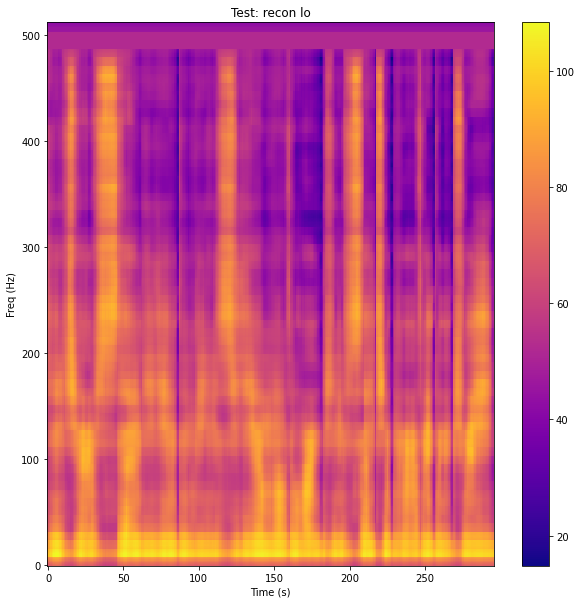

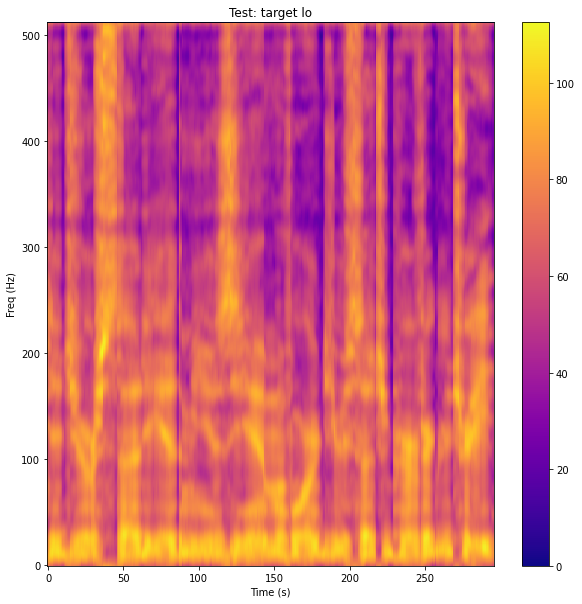

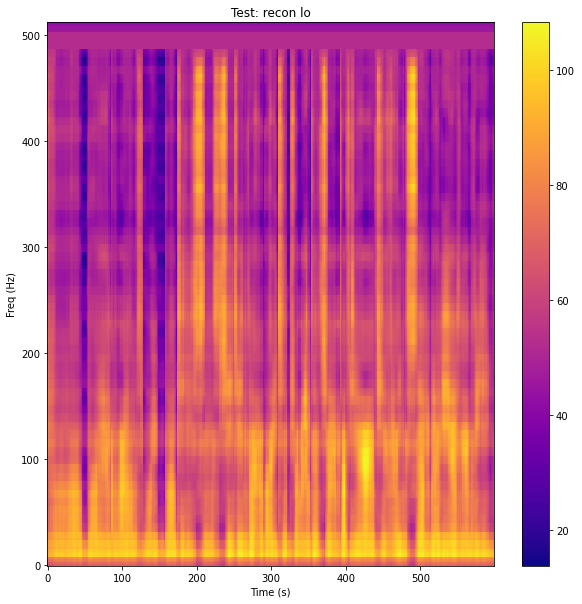

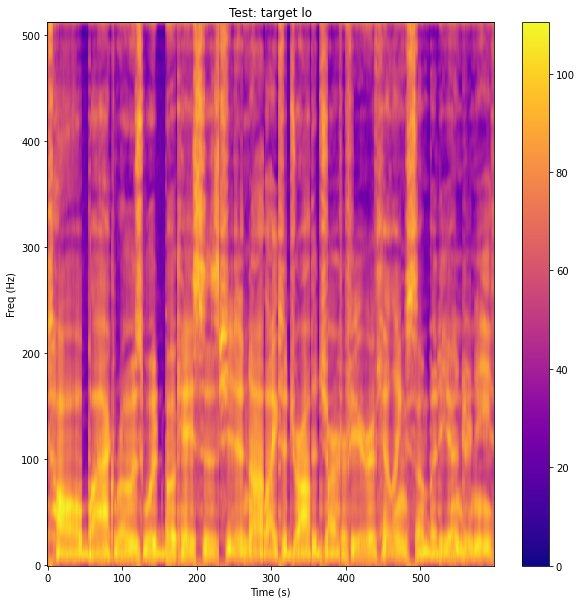

In [18]:
from models.split_model import SplitModelTaskDataset

torch.manual_seed(0)
np.random.seed(0)

def test_formant_transformer(model,
         train_source_filename, train_target_filename,
         test_input_filename, test_target_filename,
         second_train=False, vocode=True):
    def to_lo(log_amp):
        lo, hi = dft_filter(log_amp)
        return lo
    def to_hi(log_amp):
        lo, hi = dft_filter(log_amp)
        return hi
    def plot_selected_frames(selected_frames):
        plt.twinx()
        plt.scatter(np.arange(selected_frames.size), selected_frames)
    # raw audio
    task_dat = SplitModelTaskDataset(train_source_filename,
                                     train_target_filename)
    test_dat = SplitModelTaskDataset(test_input_filename, test_target_filename)
    plot_spec(log_stft(task_dat.source.amp), title='Source train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.source.selected_frames)
    sound(read_audio(train_source_filename), label='Source train')
    plot_spec(log_stft(task_dat.target.amp), title='Target train',
              figure_size=(10,10))
    plot_selected_frames(task_dat.target.selected_frames)
    sound(read_audio(train_target_filename), label='Target train')
    # aligned audio
    amp_x_aligned, amp_y_aligned = task_dat.get_as_aligned_amp()
    plot_spec(log_stft(amp_x_aligned), title='Source train aligned',
              figure_size=(10,10))
    plot_spec(log_stft(amp_y_aligned), title='Target train aligned',
          figure_size=(10,10))
    if vocode:
        aligned_1 = griffin_lim(amp_x_aligned)
        aligned_2 = griffin_lim(amp_y_aligned)
        sound(aligned_1, label='Source train aligned')
        sound(aligned_2, label='Target train aligned')
        sound((aligned_1+aligned_2)/2, label='Combined aligned')

    if second_train:
        # Generate task
        x, x_indices, y, y_indices = task_dat.get()
        x, y = log_stft(x.amp[:, x_indices]), log_stft(y.amp[:, y_indices])
        x, y = to_lo(x), to_lo(y)
        x = torch.from_numpy(x.astype(np.float32).T).to(device)
        y = torch.from_numpy(y.astype(np.float32).T).to(device)
        # transform to embedding
        with torch.no_grad():
            x = formant_coder.encode(x)
            y = formant_coder.encode(y)
        formant_transformer_optimizer_mgr.create_instance(model)
        train_formant_transformer(
            model, x, y,
            n_iter=300, log_period=5)

    def test_sample(test_task_dataset:SplitModelTaskDataset):
        from env import frame_size
        # Generate task
        x, x_indices, y, y_indices = test_task_dataset.get()
        x, y = log_stft(x.amp[:, x_indices]), log_stft(y.amp[:, y_indices])
        x, y_lo = to_lo(x), to_lo(y)
        y_hi = to_hi(y)
        x = torch.from_numpy(x.astype(np.float32).T).to(device)
        # transform to embedding
        with torch.no_grad():
            x = formant_coder.encode(x)
            x = formant_transformer.forward(x)
            x = formant_coder.decode(x)
            recon_lo = x.transpose(0,1).detach().cpu().numpy()
        plot_spec(recon_lo, title='Test: recon lo', figure_size=(10,10))
        plot_spec(y_lo, title='Test: target lo',figure_size=(10,10))
        if vocode:
            sound(griffin_lim(db_to_amp(recon_lo+y_hi)),
                  label='Test: estimate')
            sound(griffin_lim(db_to_amp(y_lo+y_hi)), label='Test: target')
    if second_train:
        test_sample(task_dat)
    test_sample(test_dat)

source_speaker_id = 0
target_speaker_id = 3
train_audio_id = 3
test_audio_id = 5
test_formant_transformer(formant_transformer,
     meta_data.get(source_speaker_id, train_audio_id),
     meta_data.get(target_speaker_id, train_audio_id),
     meta_data.get(source_speaker_id, test_audio_id),
     meta_data.get(target_speaker_id, test_audio_id),
     second_train=True, vocode=True)

# Harmonic reconstruction

In [19]:
device = torch.device('cuda')

harmonic_coder = FormantCoder().to(device)
harmonic_coder_criterion = nn.MSELoss()
if isinstance(formant_coder_criterion, nn.Module):
    harmonic_coder_criterion = harmonic_coder_criterion.to(device)
harmonic_coder_optimizer = optim.Adam(
    formant_coder.parameters(), lr=2e-3, weight_decay=0)

In [20]:
np.random.seed(0)
torch.manual_seed(0)
def train_harmonic_coder(
        model, n_iter=2000, log_period=20, test_proportion=0.3):
    model.train()
    for i in range(n_iter):
        idx = np.random.randint(auto_encoder_dataset.n_audios)
        _, x = auto_encoder_dataset[idx]
        x = torch.from_numpy(x.astype(np.float32))
        x = x.transpose(0, 1)
        x = x.to(device)
        if test_proportion is None or test_proportion == 0:
            train_x = x
        else:
            test_indices = np.random.choice(x.shape[0],
                                            int(x.shape[0] * test_proportion))
            mask = np.zeros(x.shape[0], dtype=bool)
            mask[test_indices] = True
            test_x = x[mask]
            train_x = x[~mask]
        formant_coder_optimizer.zero_grad()
        out = model(train_x)
        loss = formant_coder_criterion(out[:, :], train_x[:, :])
        loss.backward()
        formant_coder_optimizer.step()
        if log_period is not None and i % log_period == 0:
            print('Pass', i, ': ', sci(loss.item()), end='')
            if test_proportion is not None and test_proportion != 0:
                with torch.no_grad():
                    out = model(test_x)
                    loss = harmonic_coder_criterion(out[:, :], test_x[:, :])
                    print('; Test', i, ': ', sci(loss.item()), end='')
            print()
train_harmonic_coder(harmonic_coder)
save_model('saved_models/' +
           type(harmonic_coder).__name__ + '.pt', harmonic_coder)

Pass 0 :  2.410318e+02; Test 0 :  2.407465e+02
Pass 20 :  2.485357e+02; Test 20 :  2.459803e+02
Pass 40 :  2.513403e+02; Test 40 :  2.501149e+02
Pass 60 :  2.452368e+02; Test 60 :  2.436184e+02
Pass 80 :  2.448408e+02; Test 80 :  2.457001e+02
Pass 100 :  2.650816e+02; Test 100 :  2.635859e+02
Pass 120 :  2.435065e+02; Test 120 :  2.414951e+02
Pass 140 :  2.483041e+02; Test 140 :  2.457380e+02
Pass 160 :  2.487501e+02; Test 160 :  2.461696e+02
Pass 180 :  2.535691e+02; Test 180 :  2.528530e+02
Pass 200 :  2.429094e+02; Test 200 :  2.430667e+02
Pass 220 :  2.399858e+02; Test 220 :  2.403545e+02
Pass 240 :  2.504763e+02; Test 240 :  2.527516e+02
Pass 260 :  2.473927e+02; Test 260 :  2.466117e+02
Pass 280 :  2.420524e+02; Test 280 :  2.432852e+02
Pass 300 :  2.441594e+02; Test 300 :  2.457266e+02
Pass 320 :  2.449123e+02; Test 320 :  2.457930e+02
Pass 340 :  2.498133e+02; Test 340 :  2.573073e+02
Pass 360 :  2.516913e+02; Test 360 :  2.514644e+02
Pass 380 :  2.364315e+02; Test 380 :  2.364